In [8]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import itertools
import argparse
import os

from line_profiler import LineProfiler


In [3]:
time=[35]

taxas = ["Amphibians"]
models =["GAM","GBM"] 

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
elif time[0] == 85:
    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    
scenarios = ["rcp26","rcp60"]
ssprcps_shorts = ["ssp126","ssp460"]
combinations = list(itertools.product(models, model_names))

In [6]:

time=[35]

taxas = ["Amphibians"]
models =["GAM"] 

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    model_names = ['GFDL-ESM2M']
    bioscen_model_names = ['GFDL.ESM2M']
elif time[0] == 85:
    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    
scenarios = ["rcp26","rcp60"]
ssprcps_shorts = ["ssp126","ssp460"]
combinations = list(itertools.product(models, model_names))

In [38]:
da = xr.open_dataset('/storage/homefs/ch21o450/scripts/BioScenComb/data/LandClim_Output/GAM/Amphibians/GFDL-ESM2M/rcp26/Rhinella_dapsilis_[35].nc', decode_times=False)

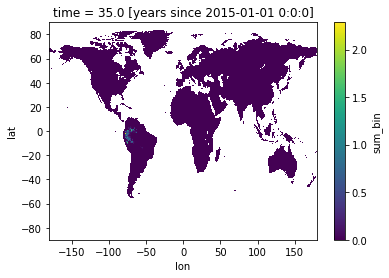

In [39]:
da.sum_bin.plot()

In [37]:
for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for model_name in model_names:
            for bioscen_model_name in bioscen_model_names:
                for scenario in scenarios:
                    for l, ssprcp_short in enumerate(ssprcps_shorts):

                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = " ".join(split_species_name)
                            formatted_names.append(formatted_species_name)

                        results = []
                        for i, species_name in enumerate(formatted_names[:2]):
                            formatted_species_name = species_name.replace(" ", "_")

                            for file_name in available_file:
                                if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                    species_file = file_name
                                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                                    break
                            else:
                                bioscen_species = None
                                continue

                            bioscen_species = pd.read_csv(dir_species + file_name)

                            available_files_iucn = formatted_species_name + ".csv"
                            if available_files_iucn in os.listdir(dir_habclass):
                                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                            else:
                                continue

                            lon = bioscen_species["x"]
                            lat = bioscen_species["y"]
                            z = bioscen_species[bioscen_model_name + '_' + scenario + '_' + selected_year]

                            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                            df = df.fillna(0)
                            convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                            Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                            keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                            split_cols = Habitats['LUH'].str.split('.', expand=True)
                            for i, key in enumerate(keys):
                                if i < len(split_cols.columns):
                                    Habitats[key] = split_cols[i]
                                else:
                                    Habitats[key] = pd.Series(dtype='float64')
                            if len(Habitats.columns) > len(keys) + 1:
                                num_missing_cols = len(Habitats.columns) - len(keys) - 1
                                Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                                Habitats.drop('LUH', axis=1, inplace=True)
                            Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                            LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                            #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                            ncfname = LandUseList
                            da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                            da_landuse = da_landuse.isel(time=time)

                            #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                            df_sdm =df

                            #build an empty np.array 
                            np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                            #isimip_lats = isimip['lat'].values
                            #isimip_lons = isimip['lon'].values

                            lats = da_landuse['lat'].values
                            lons = da_landuse['lon'].values

                            da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                            da_landclim = da_empty.assign_attrs(da_landuse)

                            keys = ["primn" if row[f"LUH{i}"] == "primn" else row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]
                            keys = list(set(keys))

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            
                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            latitudes = df_sdm['lat'].unique()
                            longitudes = df_sdm['lon'].unique()

                            lats_sorted = np.sort(latitudes)
                            lons_sorted = np.sort(longitudes)

                            newvalue_array = np.zeros((len(lats_sorted), len(lons_sorted)))
                            for i, lat in enumerate(lats_sorted):
                                for j, lon in enumerate(lons_sorted):
                                    selection = df_sdm[(df_sdm['lat'] == lat) & (df_sdm['lon'] == lon)]
                                    if not selection.empty:
                                        newvalue_array[i, j] = selection['vals'].values[0]

                            da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                            # Interpolate the values of newvalue to the dimensions of A
                            interpolated_values = da.interp(lat=lats, lon=lons)

                            # Add the interpolated values to the A DataArray
                            da_landuse['newvalue'] = interpolated_values
                            da_landuse['newvalue'] = interpolated_values.fillna(0)
                            for code in keys: 
                                # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]

                                # Select the DataArrays ending in "_bin"
                                bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin")]

                                # Multiply all the arrays together
                                sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                # Assign the "product_bin" attribute to the da_landuse DataArray
                                da_landuse["sum_bin"] = sum_bin
                                difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                                da_landuse["difference_filter"] = difference

                                da_landclim = da_landclim.assign_attrs(da_landuse)

                                da_landuse.to_netcdf("/storage/homefs/ch21o450/scripts/BioScenComb/data/LandClim_Output/" + model+ "/" + taxa + "/" + model_name + "/" + scenario + "/" + formatted_species_name + "_" + str(time)+ ".nc")

